In [1]:
import os

os.environ["JAX_PLATFORMS"] = "cpu"

In [2]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from santa import tree_packing

from santa import optimizers

/home/bamedeo/Desktop/kaggle/santa2025/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
NUM_TREES = 67
RNG = jax.random.PRNGKey(42)

In [4]:
problem = tree_packing.create_tree_packing_problem()

In [5]:
solution = problem.init_solution(NUM_TREES, rng=RNG)
solution = problem.eval(solution)
global_state = problem.init_global_state(RNG, solution=solution)

In [6]:
small_noise = optimizers.noise.BisectionNoiseOptimizer(noise_level=0.01, n_steps=2)
noise = optimizers.noise.BisectionNoiseOptimizer(noise_level=0.1, n_steps=2)

opt = optimizers.alns.AdaptiveLargeNeighborhoodSearch(
    [optimizers.ruin.RandomRuin(n_remove=1), ],
    [optimizers.recreate.RandomRecreate(max_recreate=1)],
    [noise, small_noise],
)

opt = optimizers.sa.SimulatedAnnealing(
    opt,
    initial_temp=1e3,
    cooling_rate=0.9995,
    patience=100_000
)
opt = optimizers.combine.RestoreBest(opt, patience=10_000)

opt.set_problem(problem)
opt_state = opt.init_state(solution)


@jax.jit
def iterations(sol, opt_state, global_state):
    def one_iteration(carry, _):
        sol, opt_state, global_state = carry
        sol, opt_state, global_state = opt.step(sol, opt_state, global_state)
        global_state = global_state.next()
        carry = sol, opt_state, global_state
        return carry, _

    carry = sol, opt_state, global_state
    (sol, opt_state, global_state), _ = jax.lax.scan(one_iteration, carry, length=10_000)
    return sol, opt_state, global_state


flops = iterations.lower(solution, opt_state, global_state).compile().cost_analysis()["flops"]

print(f"Flops: {int(flops)}")
with open("example_jaxpr.txt", "w") as _file:
    _file.write(jax.make_jaxpr(iterations)(solution, opt_state, global_state).pretty_print())

history = {"opt_state": [opt_state], "global_state": [global_state], "solution": [solution]}
trange = tqdm(range(500))
for it in trange:
    solution, opt_state, global_state = iterations(solution, opt_state, global_state)
    temp = opt_state.get('temperature', 0.0)
    trange.set_description(
        f"{global_state.best_feasible_score:.6f} | {solution.objective:.6f} - {solution.total_violation():.4f}"
        f"| since={global_state.iters_since_last_improvement:6d}"
        f"| temp={temp:.2f}")
    history["solution"].append(solution)
    history["opt_state"].append(opt_state)
    history["global_state"].append(global_state)

Flops: 98657


0.513542 | 0.513538 - 0.0000| since= 76550| temp=0.00: 100%|██████████| 500/500 [12:04<00:00,  1.45s/it]   


Flops: 103713

Flops: 99893 0.536141 | 0.536137 - 0.0000| since=  2652| temp=0.00:  20%|██        | 100/500 [02:23<09:17,  1.39s/it]

Flops: 98417


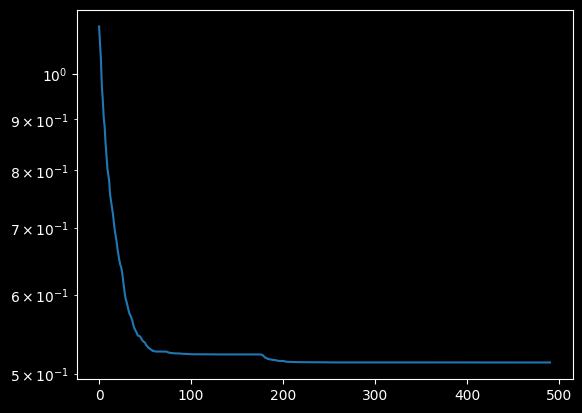

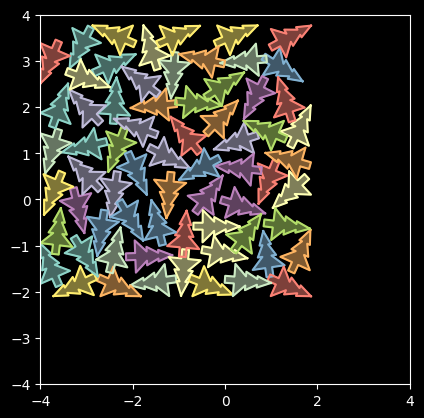

In [7]:
best_score = jax.numpy.array([h.best_score for h in history["global_state"]])
best_feasible_score = jax.numpy.array([h.best_feasible_score for h in history["global_state"]])

plt.semilogy(best_feasible_score[10:], color="tab:blue")
plt.figure()
tree_packing.plot.plot_solution(history["global_state"][-1].best_solution)

'tree_progress.gif'

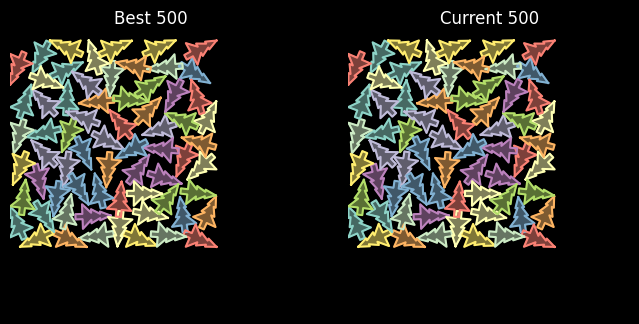

In [8]:
import matplotlib.pyplot as plt
from matplotlib import animation

best_solutions = [h.best_solution for h in history["global_state"]]
current_solutions = history["solution"]
num_frames = min(len(best_solutions), len(current_solutions))
if num_frames == 0:
    raise ValueError("No frames to render; run the optimization loop first.")

fig, axes = plt.subplots(1, 2, figsize=(8, 4))


def draw(ax, sol, title):
    ax.clear()
    plt.sca(ax)
    tree_packing.plot.plot_solution(sol, title=title)
    ax.set_axis_off()


if animation.writers.is_available("ffmpeg"):
    writer = animation.FFMpegWriter(fps=5)
    video_path = "tree_progress.mp4"
else:
    writer = animation.PillowWriter(fps=5)
    video_path = "tree_progress.gif"

with writer.saving(fig, video_path, dpi=150):
    for i in range(num_frames):
        draw(axes[0], best_solutions[i], f"Best {i}")
        draw(axes[1], current_solutions[i], f"Current {i}")
        writer.grab_frame()

video_path

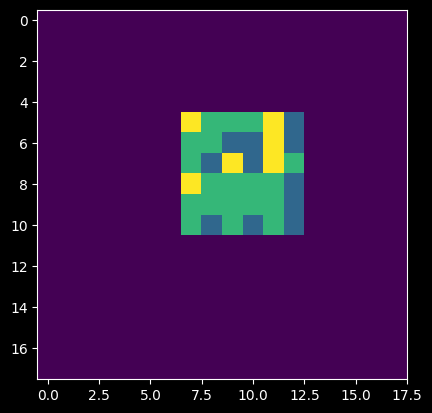

In [9]:
plt.imshow(history["global_state"][-1].best_feasible_solution.solution.aux_data["grid"].ij2n)

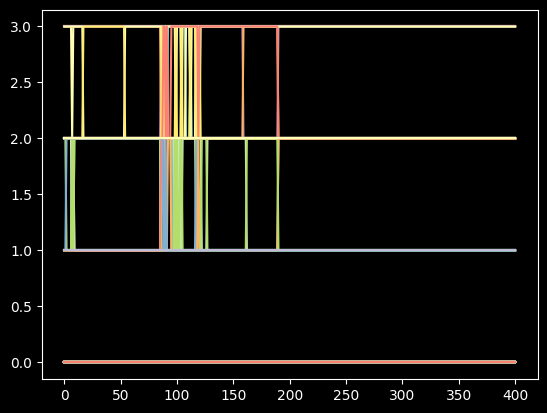

In [10]:
n = jnp.stack([h.best_feasible_solution.aux_data["grid"].ij2n.ravel() for h in history["global_state"][100:]])
plt.plot(n)